<a href="https://colab.research.google.com/github/Abishek92/robotics_tutorial/blob/master/cp314_robotics_lecture.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Iteration 0 -- loss: 1.0193
Iteration 1000 -- loss: 0.0041
Iteration 2000 -- loss: 0.0005
Iteration 3000 -- loss: 0.0014


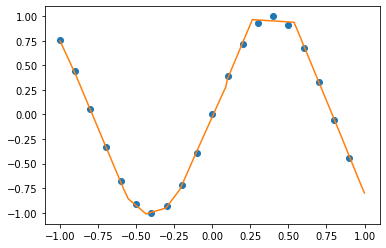

In [0]:
import numpy as np
import matplotlib.pyplot as plt

class Layer(object):
    def __init__(self):
        self.params = []
        self.grads = []
    
    def zero_grad(self):
        self.grads = [np.zeros(grad.shape) for grad in self.grads]
    
    def set_params(self, params):
        self.params = [param.copy() for param in params]

class ReLU(Layer):
    def __init__(self):
        super().__init__()
    
    def forward(self, x):
        self.history = [x.copy()]
        y = x.copy()
        y[x < 0] = 0
        return y
    
    def backward(self, dy):
        x = self.history[0]
        dx = dy.copy()
        dx[x < 0] = 0
        return dx

class Linear(Layer):
    def __init__(self, n_in, n_out):
        super().__init__()
        w = np.random.randn(n_out, n_in) # Terrible init!
        b = np.zeros((n_out,), dtype=np.float32)
        self.params = [w, b]
    
    def forward(self, x):
        # In: x has shape (batch_size, n_in)
        # Out: y has shape (batch_size, n_out)
        self.history = [x.copy()]
        w, b = self.params
        y = np.matmul(w[np.newaxis, :, :], x[:, :, np.newaxis]).squeeze(-1) + b[np.newaxis, :]
        return y;
    
    def backward(self, dy):
        # In: dy has shape (batch_size, n_out)
        # Out: dx has shape (batch_size, n_in)
        w = self.params[0]
        x = self.history[0]
        dx = np.matmul(w.T[np.newaxis, :, :], dy[:, :, np.newaxis]).squeeze(-1)
        db = dy.sum(axis=0)
        dw = np.matmul(dy[:, :, np.newaxis], x[:, np.newaxis, :]).sum(axis=0)
        self.grads = [dw, db]
        return dx

class L2Loss(Layer):
    def __init__(self):
        super().__init__()
    
    def forward(self, y_pred, y_true):
        self.history = [y_pred.copy(), y_true.copy()]
        loss = ((y_true - y_pred)**2).mean()
        return loss
    
    def backward(self, dL):
        y_pred, y_true = self.history
        dy_true = dL * 2 * (y_true - y_pred) / y_true.size
        dy_pred = dL * 2 * (y_pred - y_true) / y_pred.size
        return dy_pred, dy_true

l1 = Linear(1, 8)
l2 = ReLU()
l3 = Linear(8, 8)
l4 = ReLU()
l5 = Linear(8, 1)
l6 = L2Loss()

layers = [l1, l2, l3, l4, l5, l6]

x_gt = np.arange(-1, 1, 0.1)[:, np.newaxis]
y_gt = np.sin(4*x_gt)

for it in range(4000):
    idxs = [np.random.randint(0, x_gt.shape[0]) for _ in range(8)]
    x_train = x_gt[idxs, :]
    y_train = y_gt[idxs, :]

    for layer in layers:
        layer.zero_grad()

    # forward pass
    h1 = l1.forward(x_train)
    h2 = l2.forward(h1)
    h3 = l3.forward(h2)
    h4 = l4.forward(h3)
    h5 = l5.forward(h4)
    loss = l6.forward(h5, y_train) # loss function

    # backward pass
    dloss = 1
    dh5, _ = l6.backward(dloss)
    dh4 = l5.backward(dh5)
    dh3 = l4.backward(dh4)
    dh2 = l3.backward(dh3)
    dh1 = l2.backward(dh2)
    dx = l1.backward(dh1)

    # gradient descent step
    for layer in layers:
        layer.set_params([param - 3e-2*grad for param, grad in zip(layer.params, layer.grads)])
    
    if it % 1000 == 0: print(f'Iteration {it} -- loss: {loss:.4f}')

x_test = np.arange(-1, 1, 0.001)[:, np.newaxis]

h_test1 = l1.forward(x_test)
h_test2 = l2.forward(h_test1)
h_test3 = l3.forward(h_test2)
h_test4 = l4.forward(h_test3)
y_test = l5.forward(h_test4)

plt.plot(x_gt, y_gt, 'o')
plt.plot(x_test, y_test)
plt.show()


Iteration 0 -- loss: 0.4194
Iteration 1000 -- loss: 0.0634
Iteration 2000 -- loss: 0.0002
Iteration 3000 -- loss: 0.0010
Iteration 4000 -- loss: 0.0006


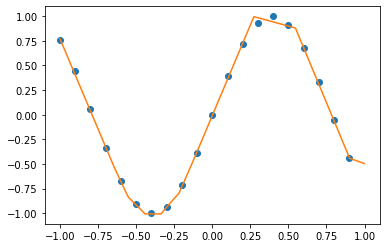

In [0]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

model = nn.Sequential(
    nn.Linear(1, 8),
    nn.ReLU(),
    nn.Linear(8, 8),
    nn.ReLU(),
    nn.Linear(8, 1)
)

criterion = nn.MSELoss()
opt = torch.optim.SGD(model.parameters(), lr=3e-2)

x_gt = np.arange(-1, 1, 0.1)[:, np.newaxis]
y_gt = np.sin(4*x_gt)

for it in range(5000):
    idxs = [np.random.randint(0, x_gt.shape[0]) for _ in range(8)]
    x_train = torch.from_numpy(x_gt[idxs, :]).float()
    y_train = torch.from_numpy(y_gt[idxs, :]).float()

    opt.zero_grad()
    y_train_pred = model(x_train)
    loss = criterion(y_train, y_train_pred)
    loss.backward()
    opt.step()

    if it % 1000 == 0: print(f'Iteration {it} -- loss: {loss:.4f}')

with torch.no_grad():
    x_test = np.arange(-1, 1, 0.001)[:, np.newaxis]
    x_test = torch.from_numpy(x_test).float()
    y_test = model(x_test)
    y_test = y_test.numpy()

plt.plot(x_gt, y_gt, 'o')
plt.plot(x_test, y_test)
plt.show()

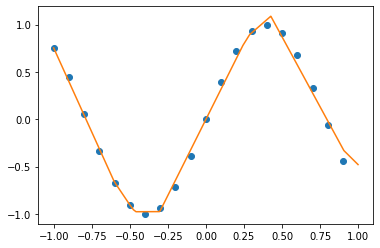

In [0]:
import numpy as np
import tensorflow as tf
import tensorflow.keras as tfk
import tensorflow.keras.layers as tfkl
import matplotlib.pyplot as plt

model = tfk.models.Sequential([
    tfkl.Dense(8, activation='relu', input_shape=(1,)),
    tfkl.Dense(8, activation='relu'),
    tfkl.Dense(1, activation=None)
])
model.compile(tfk.optimizers.SGD(3e-2), loss='mean_squared_error')

x_gt = np.arange(-1, 1, 0.1)[:, np.newaxis]
y_gt = np.sin(4*x_gt)

model.fit(x=x_gt, y=y_gt, batch_size=4, epochs=200, verbose=0)

x_test = np.arange(-1, 1, 0.001)[:, np.newaxis]
y_test = model.predict(x_test)

plt.plot(x_gt, y_gt, 'o')
plt.plot(x_test, y_test)
plt.show()

x_train: (60000, 28, 28), y_train: (60000,)
Train on 60000 samples, validate on 10000 samples
Epoch 1/5
60000/60000 [==============================] - 7s 121us/sample - loss: 0.1105 - acc: 0.9655 - val_loss: 0.0506 - val_acc: 0.9834
Epoch 2/5
60000/60000 [==============================] - 7s 119us/sample - loss: 0.0360 - acc: 0.9885 - val_loss: 0.0612 - val_acc: 0.9814
Epoch 3/5
60000/60000 [==============================] - 7s 118us/sample - loss: 0.0223 - acc: 0.9927 - val_loss: 0.0446 - val_acc: 0.9872
Epoch 4/5
60000/60000 [==============================] - 7s 116us/sample - loss: 0.0150 - acc: 0.9952 - val_loss: 0.0410 - val_acc: 0.9880
Epoch 5/5
60000/60000 [==============================] - 7s 118us/sample - loss: 0.0118 - acc: 0.9962 - val_loss: 0.0416 - val_acc: 0.9901
Test loss: 0.0415994280467392
Test accuracy: 0.9901
[[2.5147049e-11 1.4531737e-09 4.1006967e-09 2.2476275e-08 3.3688268e-09
  2.3031017e-12 1.6888444e-14 1.0000000e+00 1.1787314e-10 7.6490778e-09]]


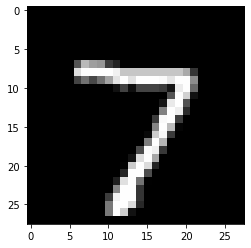

<Figure size 432x288 with 0 Axes>

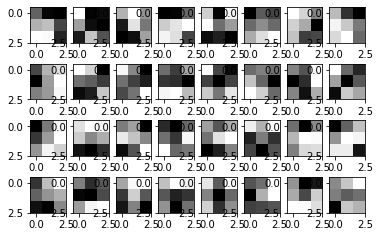

In [0]:
import numpy as np
import tensorflow as tf
import tensorflow.keras as tfk
import tensorflow.keras.layers as tfkl
import tensorflow.keras.datasets.mnist as mnist
import matplotlib.pyplot as plt

(x_train, y_train), (x_test, y_test) = mnist.load_data()
print(f'x_train: {x_train.shape}, y_train: {y_train.shape}')

x_train = x_train[:, :, :, np.newaxis].astype('float32') / 255
x_test = x_test[:, :, :, np.newaxis].astype('float32') / 255

# Input is (28, 28, 1)
model = tfk.models.Sequential([ 
    tfkl.Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(28, 28, 1), name='first_layer'), # (26, 26, 32)
    tfkl.Conv2D(64, (3, 3), activation='relu'), # (24, 24, 64)
    tfkl.MaxPooling2D(pool_size=(2, 2)), # (12, 12, 64)
    tfkl.Flatten(),
    tfkl.Dense(128, activation='relu'),
    tfkl.Dense(10, activation='softmax')
])
model.compile(tfk.optimizers.Adam(1e-3), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train
model.fit(x_train, y_train, batch_size=32, epochs=5, validation_data=(x_test, y_test))

# Evaluate test set
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

# show one output
plt.imshow(x_test[0, :, :, 0], cmap='gray')
print(model.predict(x_test[0:1]))

# visualize the first layer
w, b = model.get_layer('first_layer').get_weights()

plt.figure()
fig, axes = plt.subplots(nrows=4, ncols=8)
for i in range(32):
    axes[i//8, i % 8].imshow(w[:, :, 0, i], cmap='Greys')
plt.show()